# useful links

### https://finance.yahoo.com/quote/NOC/history?p=NOC

### https://www.datacamp.com/community/tutorials/lstm-python-stock-market#download

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('NOC.csv',usecols=['Open','High','Low','Close','Date'])
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.set_index('Date',inplace=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2769 entries, 2010-01-04 to 2020-12-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2769 non-null   float64
 1   High    2769 non-null   float64
 2   Low     2769 non-null   float64
 3   Close   2769 non-null   float64
dtypes: float64(4)
memory usage: 108.2 KB
None


,Open,High,Low,Close
Date,,,,
2010-01-04,50.686352,51.382046,50.686352,51.363976
2010-01-05,51.228451,51.906075,51.228451,51.454327
2010-01-06,51.318802,51.698269,51.129066,51.653095
2010-01-07,51.427219,52.366859,51.246521,52.186161
2010-01-08,51.833794,52.493351,51.635025,51.897041


In [3]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [4]:
train_data, test_data = train_test_split(df,random_state=42,test_size=0.2,shuffle=False) 
scaler = MinMaxScaler(feature_range = (0, 1))
window_size = 40
X_train, y_train = split_sequence(scaler.fit_transform(train_data["Close"].values.reshape(-1,1)), window_size)
X_test, y_test = split_sequence(scaler.fit_transform(test_data["Close"].values.reshape(-1,1)), window_size)

In [9]:
print('X_train: ',np.shape(X_train))
print('y_train: ',np.shape(y_train))
print('X_test: ',np.shape(X_test))
print('y_test: ',np.shape(y_test))

X_train:  (2175, 40, 1)
y_train:  (2175, 1)
X_test:  (514, 40, 1)
y_test:  (514, 1)


In [5]:
model = models.Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(layers.Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(layers.LSTM(units = 50, return_sequences = True))
model.add(layers.Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(layers.LSTM(units = 50, return_sequences = True))
model.add(layers.Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(layers.LSTM(units = 50))
model.add(layers.Dropout(0.2))
# Adding the output layer
model.add(layers.Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['accuracy'])

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
68/68 [==============================] - 11s 10ms/step - loss: 0.0445 - accuracy: 9.6363e-05
Epoch 2/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0027 - accuracy: 0.0015
Epoch 3/100
68/68 [==============================] - 1s 10ms/step - loss: 0.0022 - accuracy: 5.3215e-04
Epoch 4/100
68/68 [==============================] - 1s 10ms/step - loss: 0.0022 - accuracy: 0.0022
Epoch 5/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0020 - accuracy: 0.0012
Epoch 6/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0024 - accuracy: 6.3114e-04
Epoch 7/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0024 - accuracy: 0.0012
Epoch 8/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0020 - accuracy: 0.0011
Epoch 9/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0017 - accuracy: 8.6742e-04
Epoch 10/100
68/68 [==============================] - 1s 10ms/step - loss: 0.0016 - accur

In [10]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
y_test = scaler.inverse_transform(y_test)

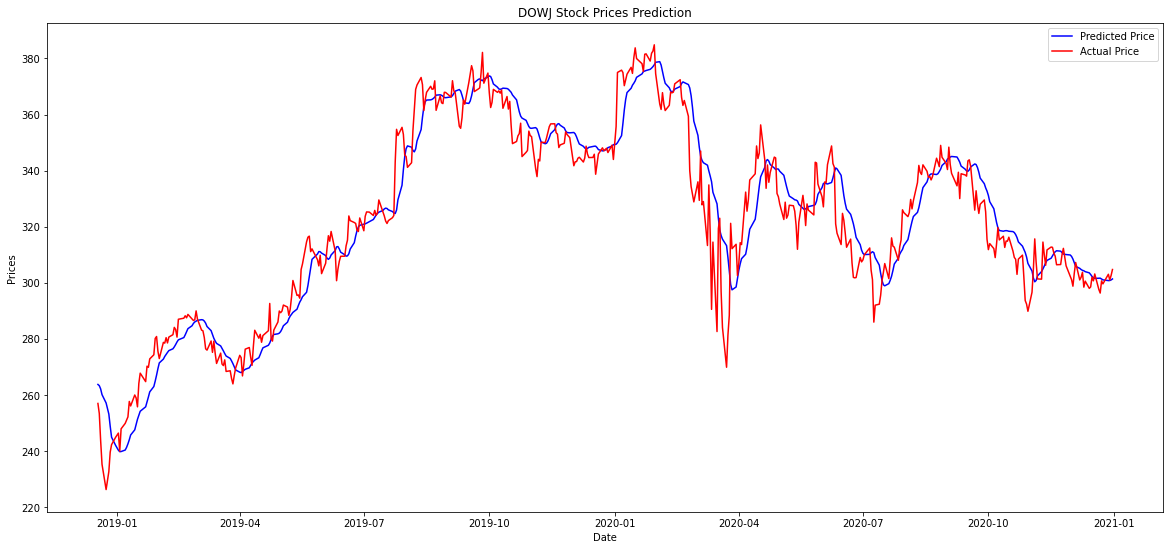

In [54]:
test_set_range = test_data[window_size:].index 
plt.figure(figsize=(20,9))
plt.plot(test_set_range, predicted_stock_price, color='blue', label='Predicted Price')
plt.plot(test_set_range, y_test, color='red', label='Actual Price')
plt.title('DOWJ Stock Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()